In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from IPython.display import display
from sklearn.tree import plot_tree
from sklearn.metrics import roc_auc_score, mean_squared_error, classification_report
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
%matplotlib inline

#### Dataset

In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
```

The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).

In [2]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"

In [3]:
!wget $data

--2023-10-22 21:32:32--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: 'housing.csv.1'

     0K .......... .......... .......... .......... ..........  3%  267K 5s
    50K .......... .......... .......... .......... ..........  7%  363K 4s
   100K .......... .......... .......... .......... .......... 10% 1.16M 3s
   150K .......... .......... .......... .......... .......... 14% 1.74M 2s
   200K .......... .......... .......... .......... .......... 17%  488K 2s
   250K .......... .......... .......... .......... .......... 21% 1.55M 2s
   300K .......... .......... .......... .......... .......... 25% 2.42M 2s
   350K ......

#### Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.
But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log transform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.


In [4]:
df = pd.read_csv(data)
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [5]:
df=df.fillna(0)

In [6]:
df = df[(df['ocean_proximity'] == '<1H OCEAN') | (df['ocean_proximity'] == 'INLAND')]

In [7]:
df['median_house_value'] = np.log1p(df['median_house_value'])

In [8]:
df_full_train,df_test = train_test_split(df,test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25,random_state = 1)

In [9]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [10]:
y_train = df_train.median_house_value.values
y_test = df_test.median_house_value.values
y_val = df_val.median_house_value.values

In [11]:
del df_train['median_house_value']
del df_test['median_house_value']
del df_val['median_house_value']

In [12]:
dv = DictVectorizer(sparse=True)

In [13]:
X_train = dv.fit_transform(df_train[df_train.columns].to_dict(orient='records'))
X_test = dv.fit_transform(df_test[df_test.columns].to_dict(orient='records'))
X_val = dv.fit_transform(df_val[df_val.columns].to_dict(orient='records'))

#### Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity`
* `total_rooms`
* `latitude`
* `population`

In [14]:
model = DecisionTreeRegressor(max_depth=1)

In [15]:
model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=1)

In [16]:
y_pred = model.predict(X_val)

In [17]:
mse = mean_squared_error(y_val, y_pred)

In [18]:
print(f"Mean Squared Error (MSE): {mse:.2f}")

Mean Squared Error (MSE): 0.20


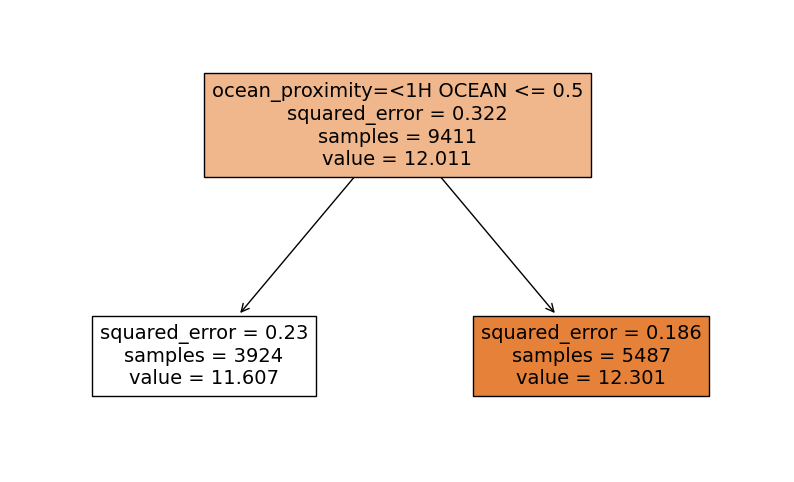

In [19]:
plt.figure(figsize=(10, 6))
plot_tree(model, filled=True, feature_names=dv.get_feature_names_out(input_features=df.columns))
plt.show()

#### Ans: Ocean proximity

#### Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* 0.245
* 0.545
* 0.845

In [20]:
random_forest = RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1)

In [21]:
random_forest.fit(X_train,y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [22]:
y_pred = random_forest.predict(X_val)

In [23]:
rmse = (mean_squared_error(y_val, y_pred))**(1/2)
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

Root Mean Squared Error (RMSE): 0.245


#### Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for retrieving the answer.

- 10
- 25
- 50
- 160

In [25]:
for n_estimators in range(10,200,10):
    random_forest = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_val)
    rmse = (mean_squared_error(y_val, y_pred)) ** (1 / 2)
    print(f"n_estimators:{n_estimators} | RMSE: {rmse:.3f}")

n_estimators:10 | RMSE: 0.245
n_estimators:20 | RMSE: 0.239
n_estimators:30 | RMSE: 0.237
n_estimators:40 | RMSE: 0.236
n_estimators:50 | RMSE: 0.235
n_estimators:60 | RMSE: 0.235
n_estimators:70 | RMSE: 0.234
n_estimators:80 | RMSE: 0.235
n_estimators:90 | RMSE: 0.235
n_estimators:100 | RMSE: 0.234
n_estimators:110 | RMSE: 0.234
n_estimators:120 | RMSE: 0.234
n_estimators:130 | RMSE: 0.234
n_estimators:140 | RMSE: 0.234
n_estimators:150 | RMSE: 0.234
n_estimators:160 | RMSE: 0.233
n_estimators:170 | RMSE: 0.233
n_estimators:180 | RMSE: 0.234
n_estimators:190 | RMSE: 0.234


#### Ans: 160

#### Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25

In [30]:
for max_depth in [10,15,20,25]:
    random_forest = RandomForestRegressor(max_depth, random_state=1, n_jobs=-1)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_val)
    rmse = (mean_squared_error(y_val, y_pred)) ** (1 / 2)
    print(f"max_depth:{max_depth} | RMSE: {rmse:.3f}")

max_depth:10 | RMSE: 0.245
max_depth:15 | RMSE: 0.242
max_depth:20 | RMSE: 0.239
max_depth:25 | RMSE: 0.238


#### Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income`
* `total_bedrooms`
* `longitude`


In [31]:
model = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")

feature_names = df_train.columns
feature_importances = model.feature_importances_
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Mean Squared Error (MSE): 0.06
Feature: total_bedrooms, Importance: 0.3356
Feature: population, Importance: 0.2925
Feature: housing_median_age, Importance: 0.1020
Feature: total_rooms, Importance: 0.0862
Feature: households, Importance: 0.0738
Feature: latitude, Importance: 0.0303
Feature: median_income, Importance: 0.0271
Feature: ocean_proximity, Importance: 0.0159
Feature: longitude, Importance: 0.0151


#### Ans:total_bedrooms

#### Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value


In [32]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [34]:
# Create DMatrix for the training and validation sets
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [35]:
# Create a watchlist
watchlist = [(dtrain, 'train'), (dval, 'validation')]

In [36]:
# Train the model with eta = 0.3
num_round = 100
model_eta_0_3 = xgb.train(xgb_params, dtrain, num_round, evals=watchlist)

[0]	train-rmse:0.44350	validation-rmse:0.44250
[1]	train-rmse:0.36599	validation-rmse:0.36916
[2]	train-rmse:0.31556	validation-rmse:0.32382
[3]	train-rmse:0.28541	validation-rmse:0.29965
[4]	train-rmse:0.26573	validation-rmse:0.28417
[5]	train-rmse:0.25338	validation-rmse:0.27463
[6]	train-rmse:0.24157	validation-rmse:0.26770
[7]	train-rmse:0.23486	validation-rmse:0.26423
[8]	train-rmse:0.22668	validation-rmse:0.25820
[9]	train-rmse:0.21995	validation-rmse:0.25444
[10]	train-rmse:0.21444	validation-rmse:0.25179
[11]	train-rmse:0.21155	validation-rmse:0.25054
[12]	train-rmse:0.20729	validation-rmse:0.24791
[13]	train-rmse:0.20317	validation-rmse:0.24628
[14]	train-rmse:0.20135	validation-rmse:0.24630
[15]	train-rmse:0.19858	validation-rmse:0.24522
[16]	train-rmse:0.19580	validation-rmse:0.24445
[17]	train-rmse:0.19333	validation-rmse:0.24395
[18]	train-rmse:0.19107	validation-rmse:0.24284
[19]	train-rmse:0.18735	validation-rmse:0.24127
[20]	train-rmse:0.18524	validation-rmse:0.23978
[2

In [37]:
# Make predictions with the model
y_pred_eta_0_3 = model_eta_0_3.predict(dval)

In [38]:
# Calculate RMSE for eta = 0.3
rmse_eta_0_3 = mean_squared_error(y_val, y_pred_eta_0_3, squared=False)
print(f"RMSE (eta = 0.3): {rmse_eta_0_3:.5f}")

RMSE (eta = 0.3): 0.22862


In [39]:
# Now change eta to 0.1
xgb_params['eta'] = 0.1

In [40]:
# Train the model with eta = 0.1
model_eta_0_1 = xgb.train(xgb_params, dtrain, num_round, evals=watchlist)

[0]	train-rmse:0.52449	validation-rmse:0.52045
[1]	train-rmse:0.48736	validation-rmse:0.48443
[2]	train-rmse:0.45433	validation-rmse:0.45293
[3]	train-rmse:0.42533	validation-rmse:0.42550
[4]	train-rmse:0.39987	validation-rmse:0.40144
[5]	train-rmse:0.37822	validation-rmse:0.38151
[6]	train-rmse:0.35887	validation-rmse:0.36393
[7]	train-rmse:0.34177	validation-rmse:0.34838
[8]	train-rmse:0.32701	validation-rmse:0.33492
[9]	train-rmse:0.31411	validation-rmse:0.32333
[10]	train-rmse:0.30326	validation-rmse:0.31427
[11]	train-rmse:0.29355	validation-rmse:0.30615
[12]	train-rmse:0.28519	validation-rmse:0.29922
[13]	train-rmse:0.27760	validation-rmse:0.29269
[14]	train-rmse:0.27116	validation-rmse:0.28796
[15]	train-rmse:0.26538	validation-rmse:0.28380
[16]	train-rmse:0.26012	validation-rmse:0.27970
[17]	train-rmse:0.25583	validation-rmse:0.27661
[18]	train-rmse:0.25203	validation-rmse:0.27388
[19]	train-rmse:0.24818	validation-rmse:0.27123
[20]	train-rmse:0.24512	validation-rmse:0.26882
[2

In [41]:
# Make predictions with the model
y_pred_eta_0_1 = model_eta_0_1.predict(dval)

# Calculate RMSE for eta = 0.1
rmse_eta_0_1 = mean_squared_error(y_val, y_pred_eta_0_1, squared=False)
print(f"RMSE (eta = 0.1): {rmse_eta_0_1:.5f}")

RMSE (eta = 0.1): 0.23209


#### Ans: 0.22862